*Aprenentatge Computacional*

**Autor:**
- Sebastian Malbaceda Leyva (1681519)


# Cas Kaggle - Student Alcohol Consumption

En aquesta pràctica s'abordarà la creació d'un model d'aprenentatge computacional enfocat en classificació. Aquest model s'encarregarà de predir el nivell de consum d'alcohol dels estudiants als caps de setmana. Per poder aconseguir això, s'ha pogut recollir una sèrie de dades d'un institut. Aquestes dades són una sèrie de característiques de cada estudiant on es pot trobar informació tant relacionada amb l'ambient on es troba com amb el rendiment acadèmic que ha demostrat.

Per poder obtenir el millor model possible, seguirem una sèrie de passos on analitzarem les dades obtingudes, les processarem, triarem una sèrie de models candidats per entrenar i analitzarem els resultats obtinguts, decidint el millor classificador.

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades.

In [768]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import StandardScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

### 1. EDA (exploratory data analysis)

Previ a observar el dataset, hem de carregar tot el necessari per poder començar a treballar.

A la pàgina del cas Kaggle es pot trobar informació dels datasets que es carreguen. El que faré és utilitzar els dos datasets que pertanyen a dos grups d'alumnes d'un cert institut. Un d'ells és el de la classe de matemàtiques i l'altre és el dels alumnes de portuguès.

Per a l'anàlisi de dades, el que es farà serà utilitzar els dos datasets de manera concatenada, és a dir, juntarem tots dos datasets per poder tenir un model més estable. Segons certes aclaracions a la pàgina de Kaggle, hi ha alumnes que poden pertànyer a les dues classes, així que s'aconsella tractar de filtrar aquests alumnes. Es menciona breument que aquells alumnes amb atributs idèntics són els que pertanyen a totes dues classes. Potser no és del tot clar, però considerarem que si un registre és exactament idèntic a un altre, serà eliminat, quedant-nos només amb un d'ells. Per tant, el que farem serà concatenar els datasets i eliminar els duplicats.

In [769]:
dataset_math = pd.read_csv("data/student-mat.csv")
dataset_por = pd.read_csv("data/student-por.csv")

dataset = pd.concat([dataset_math, dataset_por], ignore_index=True)
dataset = dataset.drop_duplicates()

A continuació es farà la partició del dataset resultant considerant la característica objectiu a predir. En aquest cas, com es suggereix al títol, ens centrarem a predir el nivell d'alcohol, de manera que analitzarem aquelles característiques que influeixen en aquest.

Hi ha dues característiques principals que fan referència al consum, com per exemple Walc (consum d'alcohol els caps de setmana) i, per altra banda, Dalc, que fa referència al nivell de consum d'alcohol els dies laborals.

En aquesta pràctica ens centrarem a predir el Walc, ja que és més probable que tingui un impacte més gran en estudiants joves. Descartem Dalc perquè potser no tots els estudiants treballen des de joves o no té massa pes si ens referim als dies hàbils.

Veurem graficament el dataset abants de fer la particio en test i train

Comptatge de cada classe:
Walc
1    398
2    235
3    200
4    138
5     73


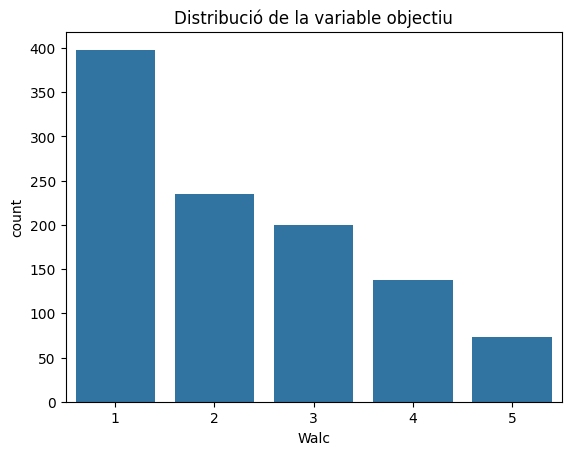

In [770]:
class_counts = dataset['Walc'].value_counts()
print("Comptatge de cada classe:")
print(class_counts.to_string())

sns.countplot(x='Walc', data=dataset)
plt.title('Distribució de la variable objectiu')
plt.show()

Vist la proporció dels 5 nivells de consum, observem clarament un desbalanç considerable i una forta tendència a haver-hi més alumnes que consumeixen poc alcohol. El nivell 1 indica baix consum, mentre que el nivell 5 indica consum alt.

En tenir molt poques mostres d'alumnes que consumeixen molt alcohol, prendrem la decisió de destinar un 80% de les dades al train i un 20% a la part de test, a més a més de que es farà una partició equilibrada.

In [771]:
train, test = train_test_split(dataset, train_size=0.7, stratify=dataset['Walc'], random_state=42)

dataset.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


Procedirem a mostrar les dimensions obtingudes tant del dataset amb el qual treballem com del train que analitzarem i del test.

In [772]:
print("El nombre de mostres que tenim a la base de dades és de",dataset.shape[0])
print("El nombre de atributs que tenim a la base de dades és de",dataset.shape[1])

print("El nombre de mostres que tenim al train és de",train.shape[0])
print("El nombre de atributs que tenim al train és de",train.shape[1])

print("El nombre de mostres que tenim al test és de",test.shape[0])
print("El nombre de atributs que tenim al test és de",test.shape[1])

El nombre de mostres que tenim a la base de dades és de 1044
El nombre de atributs que tenim a la base de dades és de 33
El nombre de mostres que tenim al train és de 730
El nombre de atributs que tenim al train és de 33
El nombre de mostres que tenim al test és de 314
El nombre de atributs que tenim al test és de 33


Tenim una mida decent per part del dataset complet i d'igual manera con s'ha mencionat el train i el test seràn proporcionals al dataset.

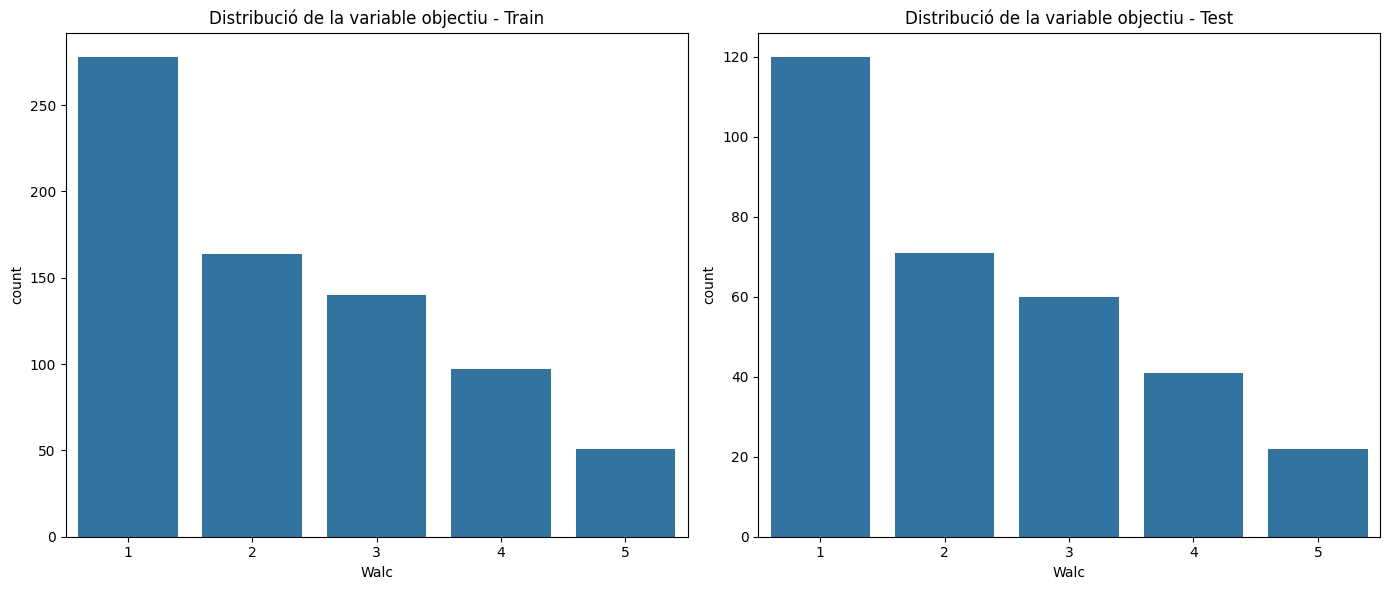

In [773]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila y 2 columnas

sns.countplot(x='Walc', data=train, ax=axes[0])
axes[0].set_title('Distribució de la variable objectiu - Train')

sns.countplot(x='Walc', data=test, ax=axes[1])
axes[1].set_title('Distribució de la variable objectiu - Test')

plt.tight_layout()
plt.show()

Es pot veure que disposem de 33 atributs diferents amb un total de 835 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del cosnum.

In [774]:
print("Informació de cada atribut:")
print(dataset.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non

- school: Fa referència a l'escola on estudia l'estudiant. És una variable binària que pot tenir dos valors possibles: 'GP' per Gabriel Pereira o 'MS' per Mousinho da Silveira, que són els noms de dues escoles diferents.

- sex: Indica el sexe de l'estudiant. És una variable binària on 'F' representa una dona i 'M' un home.

- age: És l'edat de l'estudiant, una variable numèrica que oscil·la entre els 15 i els 22 anys.

- address: Tipus d'adreça de la llar de l'estudiant. Aquesta variable és binària, amb 'U' per indicar que l'estudiant viu en una zona urbana i 'R' per indicar una zona rural.

- famsize: Fa referència a la mida de la família de l'estudiant. És també una variable binària on 'LE3' indica que la família té tres membres o menys i 'GT3' significa que la família té més de tres membres.

- Pstatus: Indica l'estat de convivència dels pares de l'estudiant. Pot ser 'T' per pares que viuen junts o 'A' per pares separats.

- Medu: Aquesta variable indica el nivell educatiu de la mare de l'estudiant. És numèrica i pot prendre els següents valors: 0 per cap educació, 1 per educació primària (fins al quart grau), 2 per educació de 5è a 9è grau, 3 per educació secundària, o 4 per educació superior.

- Fedu: Al igual que la variable anterior, Fedu indica el nivell educatiu del pare de l'estudiant amb els mateixos valors: 0 per cap educació, 1 per educació primària, 2 per educació de 5è a 9è grau, 3 per educació secundària, i 4 per educació superior.

- Mjob: La professió de la mare de l'estudiant. És una variable nominal que pot ser una de les següents: 'teacher' (mestra), relacionada amb la salut (salut), 'services' (com serveis civils com la policia o administració), 'at_home' (a casa), o 'other' (altres).

- Fjob: Fa referència a la professió del pare de l'estudiant, amb les mateixes opcions que la variable Mjob: 'teacher', 'health', 'services', 'at_home' i 'other'.

- reason: Motiu pel qual l'estudiant va triar aquesta escola en particular. Pot ser un dels següents: 'home' (perquè està a prop de casa), 'reputation' (per la bona reputació de l'escola), 'course' (preferència per l'assignatura), o 'other' (altres raons).

- guardian: Aquesta variable indica qui és el tutor legal de l'estudiant. Pot ser 'mother' (mare), 'father' (pare), o 'other' (un altre tutor).

- traveltime: Temps de desplaçament entre la casa i l'escola. És una variable numèrica on el valor pot ser 1 (menys de 15 minuts), 2 (de 15 a 30 minuts), 3 (de 30 minuts a 1 hora), o 4 (més d'1 hora).

- studytime: Temps d'estudi setmanal de l'estudiant. És també una variable numèrica amb els següents valors: 1 (menys de 2 hores), 2 (de 2 a 5 hores), 3 (de 5 a 10 hores), o 4 (més de 10 hores).

- failures: Nombre de suspensos en anteriors classes. És una variable numèrica on el valor pot ser 1, 2, o 3 si el nombre de suspensos és menor que 3, i 4 si l'estudiant ha suspès 3 o més classes.

- schoolsup: Indica si l'estudiant rep suport educatiu extra fora de les hores lectives. És binària, amb 'sí' o 'no'.

- famsup: Fa referència a si l'estudiant rep suport educatiu per part de la seva família. Aquesta també és una variable binària amb les opcions 'sí' o 'no'.

- paid: Aquesta variable indica si l'estudiant participa en classes pagades extra relacionades amb la matèria del curs, ja sigui Matemàtiques o Portuguès. També és binària, amb 'sí' o 'no'.

- activities: Indica si l'estudiant participa en activitats extraescolars. És una variable binària amb 'sí' o 'no'.

- nursery: Fa referència si l'estudiant va assistir a una escola bressol abans de començar l'escola primària. Pot ser 'sí' o 'no'.

- higher: Indica si l'estudiant té la intenció de continuar els seus estudis amb educació superior. També és binària, amb 'sí' o 'no'.

- internet: Aquesta variable indica si l'estudiant té accés a Internet a casa seva. És binària, amb 'sí' o 'no'.

- romantic: Indica si l'estudiant està en una relació romàntica. És binària, amb 'sí' o 'no'.

- famrel: Fa referència a la qualitat de les relacions familiars de l'estudiant. Aquesta és una variable numèrica, amb una escala de 1 (molt dolent) a 5 (excel·lent).

- freetime: Temps lliure que l'estudiant té després de l'escola. És una variable numèrica, amb una escala de 1 (molt baix) a 5 (molt alt).

- goout: Indica com d'apassionat és l'estudiant de sortir amb els seus amics. Aquesta variable numèrica té una escala de 1 (molt poc) a 5 (molt sovint).

- Dalc: Indica el consum d'alcohol de l'estudiant en dies laborables. És una variable numèrica, amb valors entre 1 (molt baix) i 5 (molt alt).

- Walc: Aquesta variable fa referència al consum d'alcohol durant els caps de setmana. Igual que Dalc, és una variable numèrica amb valors entre 1 (molt baix) i 5 (molt alt). (TARGET)

- health: Està relacionada amb l'estat de salut actual de l'estudiant. És una variable numèrica que va de 1 (molt dolent) a 5 (molt bo).

- absences: Indica el nombre d'absències que l'estudiant ha tingut a l'escola. Aquesta és una variable numèrica que pot oscil·lar entre 0 i 93.


- G1: Qualificació obtinguda per l'estudiant en el primer període del curs. És una variable numèrica que va de 0 a 20.

- G2: Qualificació obtinguda per l'estudiant en el segon període del curs. Aquesta també és una variable numèrica, de 0 a 20.

- G3: És la qualificació final obtinguda en l'assignatura, que pot ser un valor entre 0 i 20.

Les característiques es poden clasificar en tres grups:

Numeriques: 
'age', 'absences', 'G1', 'G2', 'G3'

Nominals:
'school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'

Ordinals:
'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health'

Algunes característiques tenen només dues opcions possibles (per exemple, 'school', 'sex', 'address', etc.), per això les hem considerat com a binàries. Si les tractéssim com a variables nominales, el model hauria de crear més columnes per a cada possible valor (segons al codificar), el que augmentaria la complexitat i el temps d'entrenament. Per tant, mantenim aquestes característiques en una sola columna, evitant així un sobreentrenament i millorant l'eficiència del model.

Per altra banda, les característiques nominals que no són binàries, com 'Mjob', 'Fjob', 'reason' o 'guardian', les hem separades com a categòriques nominals perquè cada valor pot tenir més d'una categoria, però no tenen un ordre inherent.

Les característiques ordinals, com 'Medu', 'Fedu', 'traveltime', etc., les hem classificat en una categoria separada perquè tenen un ordre natural, però la distància entre els valors no és necessàriament uniforme. A aquestes se les tractarà com a variables ordinals, mantenint l'ordre dels valors per millorar la capacitat del model d'interpretar-les. L'objectiu Walc es oridnal.

Finalment, les característiques numèriques com 'age', 'absences', 'G1', 'G2', 'G3' es mantenen en la seva categoria respectiva, ja que representen quantitats contínues que el model pot processar directament sense necessitat de convertir-les en categories. 



Les característiques es classifiquen en quatre grups:

Categorical Binary Features:
'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'


Categorical Nominal Features:
'Mjob', 'Fjob', 'reason', 'guardian'


Categorical Ordinal Features:
'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health'


Categorical Numerical Features:
'age', 'absences', 'G1', 'G2', 'G3', 'academic_social_index'


Ara ens toca observar si tenim presència de Nans al nostre dataset. Si és cert, haurem de tractar tant el train com el test, on el test haurà d'agafar informació del train en cas que es vulgui fer completament de Nans, ja sigui per mitjana, moda o algun tractament de completació especialment convenient, sempre en tot moment evitant de comentre data leakage.

Per identificar-lo més visualment dibuixarem una gràfica:

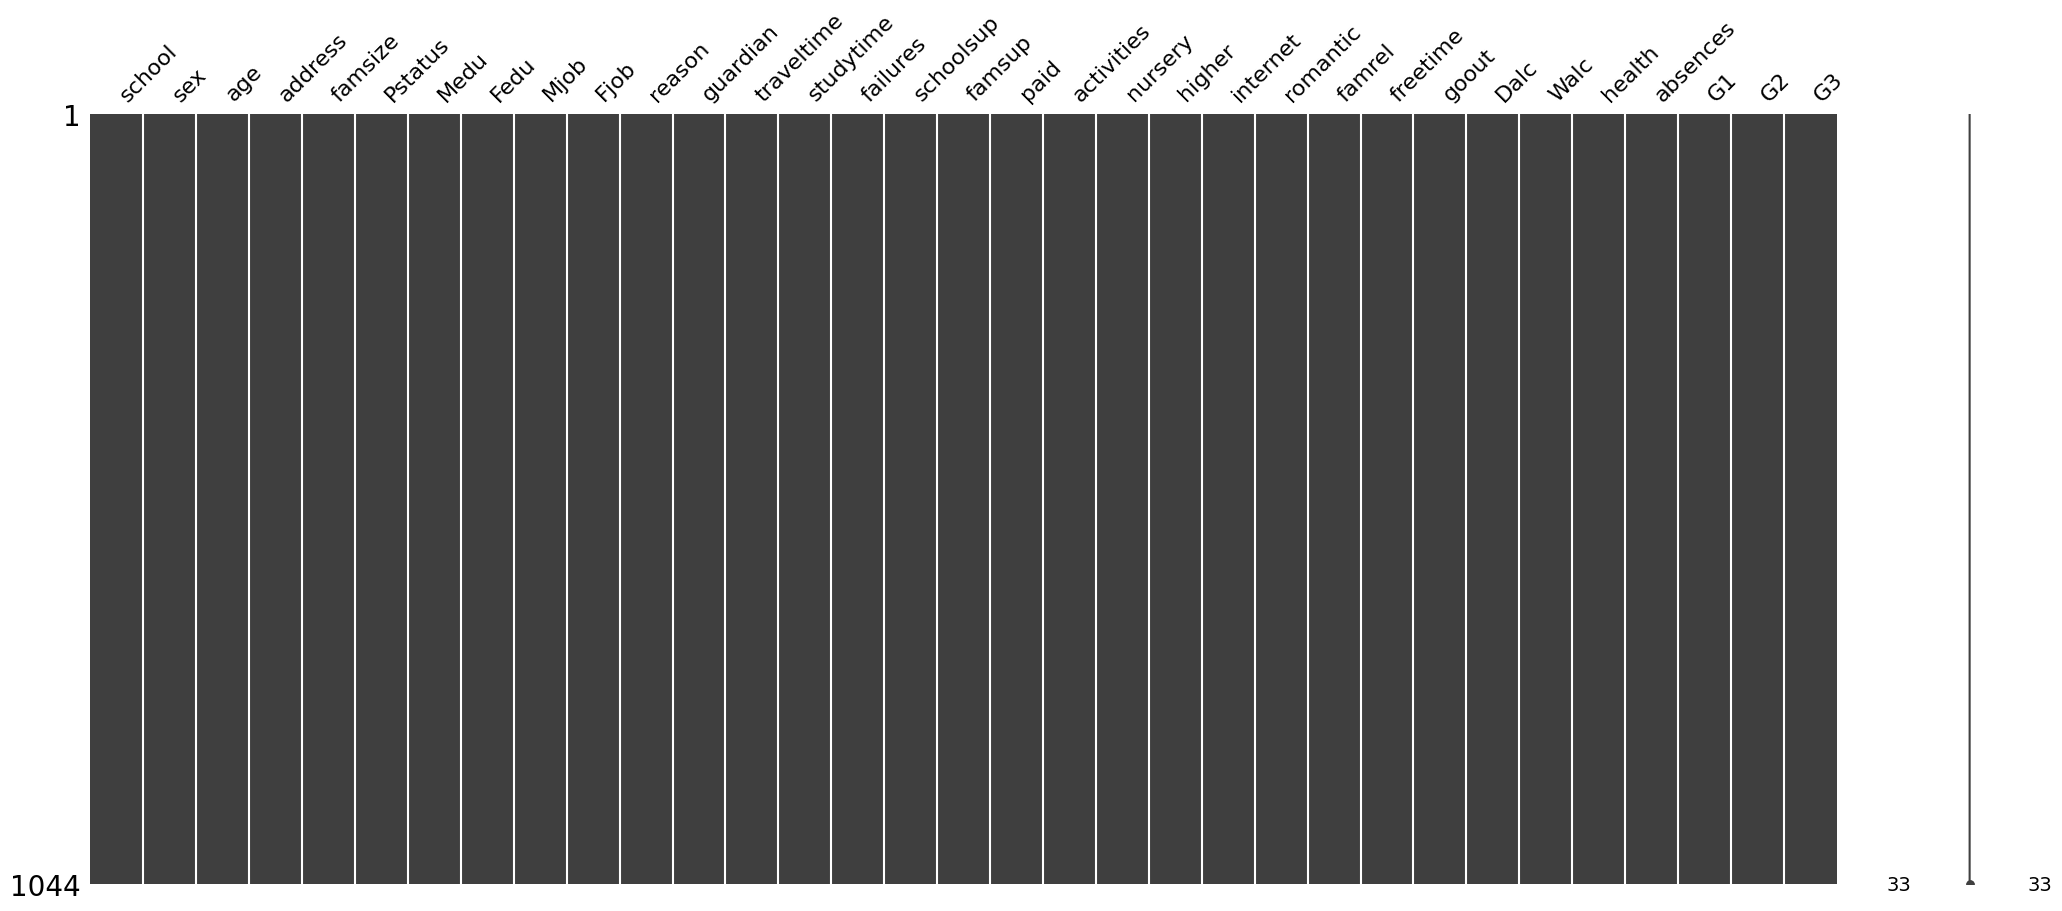

In [775]:
msno.matrix(dataset)
plt.show()

Després d'examinar el nostre dataset, podem confirmar que no hi ha valors nuls o faltants (Nans) presents en les dades. Tots els atributs del conjunt de dades estan complets, per la qual cosa no serà necessari realitzar cap tipus de tractament per gestionar aquests valors, com ara la imputació per mitjana, moda o altres tècniques de completació. Això ens permet treballar directament amb les dades disponibles sense la necessitat de dur a terme cap procés addicional de neteja o substitució de valors.

Ara es farà l'anàlisi de la relació entre els atributs d'entrada (X o features) i la variable objectiu (y o target). Per facilitar l'anàlisi, dividirem aquest estudi en dues parts:

**Atributs numèrics (numeriques i ordinals)**: Explorarem com les variables numèriques es relacionen amb la variable objectiu. Utilitzarem tècniques com la correlació (coeficient de Pearson) per identificar els possibles patrons entre aquestes variables.

Es mostren característiques abans de ser codificades, desprès de la codificacioó es tornara a fer el mateix.

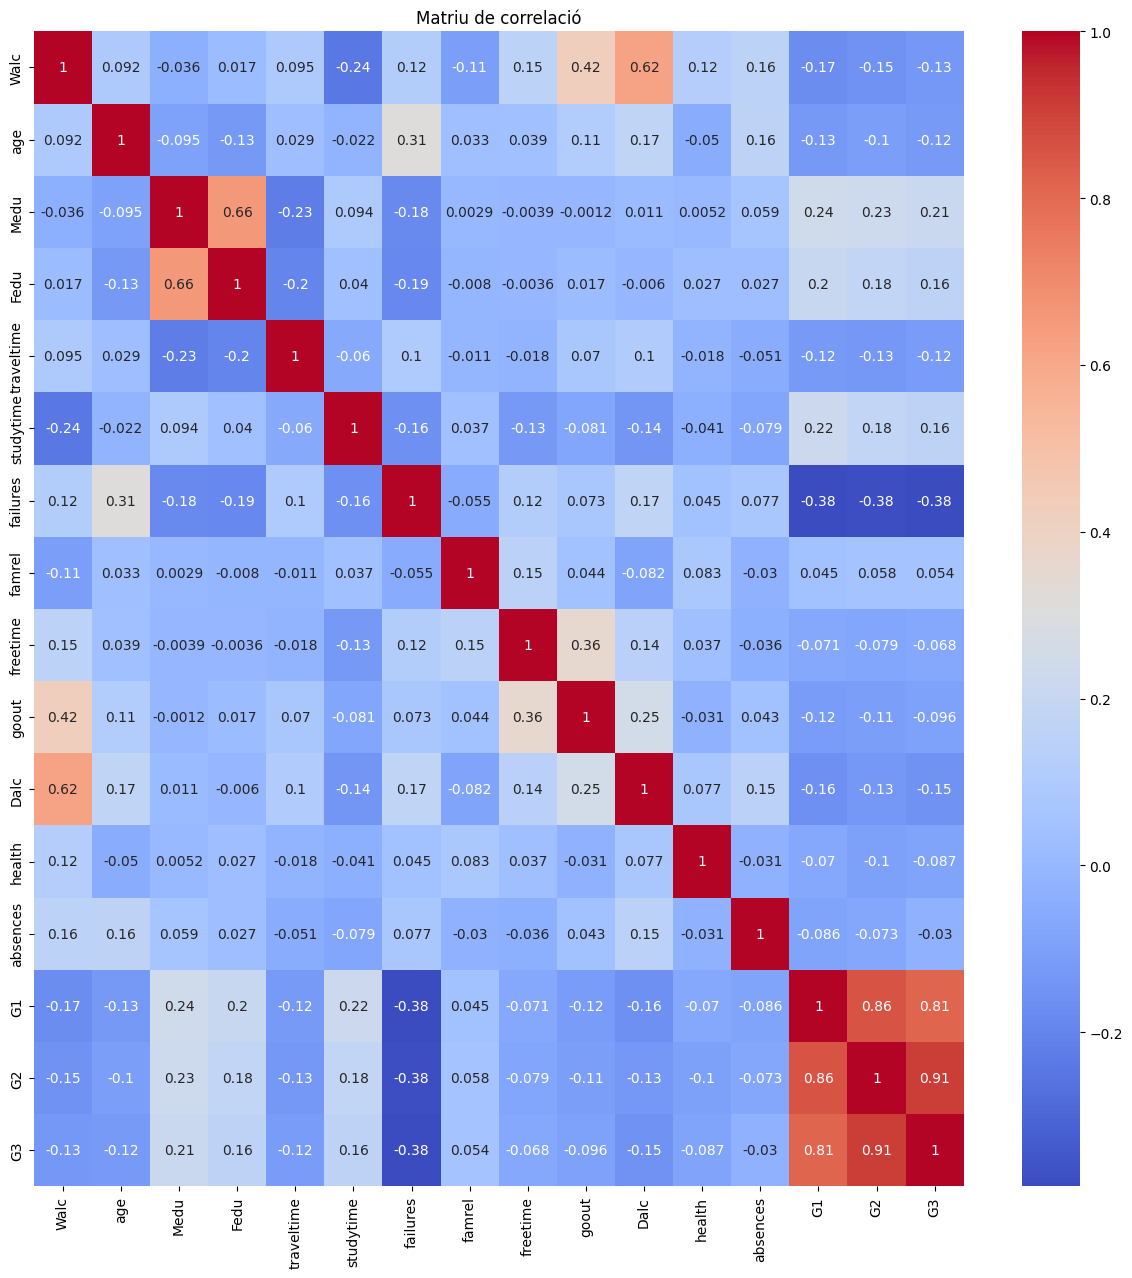

In [776]:
nume_features = ['Walc', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health', 'absences', 'G1', 'G2', 'G3']
corr_matrix = train[nume_features].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()

A continuació es descriuen les diferents correlacions entre els atributs numèrics i el target (consum d'alcohol durant el cap de setmana, Walc):

- Dalc i Walc (0.63): La forta correlació positiva entre el consum d'alcohol durant els dies laborables (Dalc) i el consum durant el cap de setmana (Walc) indica que els estudiants que consumeixen alcohol durant la setmana també tendeixen a fer-ho durant els caps de setmana. Això suggereix patrons de consum més constants i un possible risc de consum habitual.
- goout i Walc (0.41): Existeix una correlació positiva moderada entre la freqüència de sortides amb amics i el consum d'alcohol durant el cap de setmana. Aquest resultat és esperable, ja que sortir amb amics en contextos informals o festius sovint està associat amb un augment del consum d'alcohol.

- studytime i Walc (-0.23): Es detecta una correlació negativa feble entre el temps d'estudi setmanal i el consum d'alcohol durant el cap de setmana. Aquesta relació, tot i no ser molt significativa, té sentit en el context de que els estudiants que consumeixen alcohol amb més freqüència els caps de setmana podrien dedicar menys temps a l'estudi, ja que poden prioritzar les activitats socials per sobre de les acadèmiques.

- absences i Walc (0.16): La correlació positiva feble entre les absències escolars i el consum d'alcohol durant el cap de setmana podria indicar que els estudiants que consumixen alcohol en excés també tenen més probabilitats de faltar a classe, especialment després de caps de setmana amb molta festa.

- freetime i Walc (0.15): La relació positiva feble suggereix que més temps lliure podria traduir-se en més oportunitats per consumir alcohol, especialment durant els caps de setmana, quan els estudiants tenen més temps per dedicar a activitats socials.

- health i Walc (0.11): La correlació positiva feble entre la salut percebuda pels estudiants i el consum d'alcohol durant el cap de setmana podria indicar que els estudiants amb millor salut podrien estar més disposats a consumir alcohol durant els seus temps lliures, ja que no perceben efectes negatius immediats sobre la seva salut. Aquesta relació pot suggerir que aquells amb millor salut se senten més capacitats per participar en activitats socials, com sortir i consumir alcohol, sense percebre un impacte significatiu en el seu benestar.

- famrel i Walc (-0.11): La correlació negativa feble entre la qualitat de les relacions familiars i el consum d'alcohol durant el cap de setmana indica que els estudiants amb un entorn familiar més fort i amb més suport emocional tendeixen a consumir menys alcohol, ja que reben més acompanyament i supervisió.

- traveltime i Walc (0.096): La correlació positiva bastant feble suggereix que els estudiants amb desplaçaments més llargs podrien tenir un estil de vida més independent, el que podria portar a un augment en el consum d'alcohol durant els caps de setmana.

- failures i Walc (0.092): Existeix una correlació positiva molt feble entre el nombre de suspensos i el consum d'alcohol durant el cap de setmana. Això pot indicar que el consum freqüent d'alcohol podria afectar negativament el rendiment acadèmic, ja sigui per la reducció del temps d'estudi o per una menor capacitat de concentració.

- age i Walc (0.085): Tot i que la correlació és molt feble, s'observa una relació positiva entre l'edat i el consum d'alcohol durant els caps de setmana. Aquesta relació és coherent amb la tendència dels estudiants més grans a tenir més llibertat i oportunitats per sortir i experimentar amb l'alcohol.

- G1, G2, G3 i Walc (-0.11, -0.14, -0.16): La correlació negativa entre les qualificacions acadèmiques (notes G1, G2 i G3) i el consum d'alcohol durant els caps de setmana suggereix que els estudiants que consumeixen més alcohol tendeixen a obtenir pitjors resultats acadèmics. Això podria ser causat per la disminució del temps d'estudi, la fatiga o la dificultat per concentrar-se a causa del consum excessiu d'alcohol.

Entre altres que no s'han considerat per la seva baixa correlacio.

Les correlacions esmentades anteriorment són orientatives, però no afirmen de manera rotunda que la relació sigui exactament com es descriu. El coeficient de correlació és més significatiu per a característiques quantitatives, com les notes G1, G2, G3 o el nombre d'absències. El que vull dir és que, tot i que es poden presentar característiques nominals en format ordinal, aquestes poden ser malinterpretades i portar a errors en la interpretació de les correlacions.

La idea principal aquí es aclarir que, tot i que les correlacions poden ser útils, cal tenir en compte que algunes característiques, especialment les nominals o ordinals, poden ser interpretades incorrectament i donar lloc a conclusions errònies

**Atributs categòrics**: Analitzarem la relació entre les variables categòriques i la variable objectiu, utilitzant gràfics per observar com la distribució de les diferents categories influeix en la predicció. El següent gràfic mostra la taxa de consum d'alcohol al caps de setmana en funció variables categòriques: school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic.

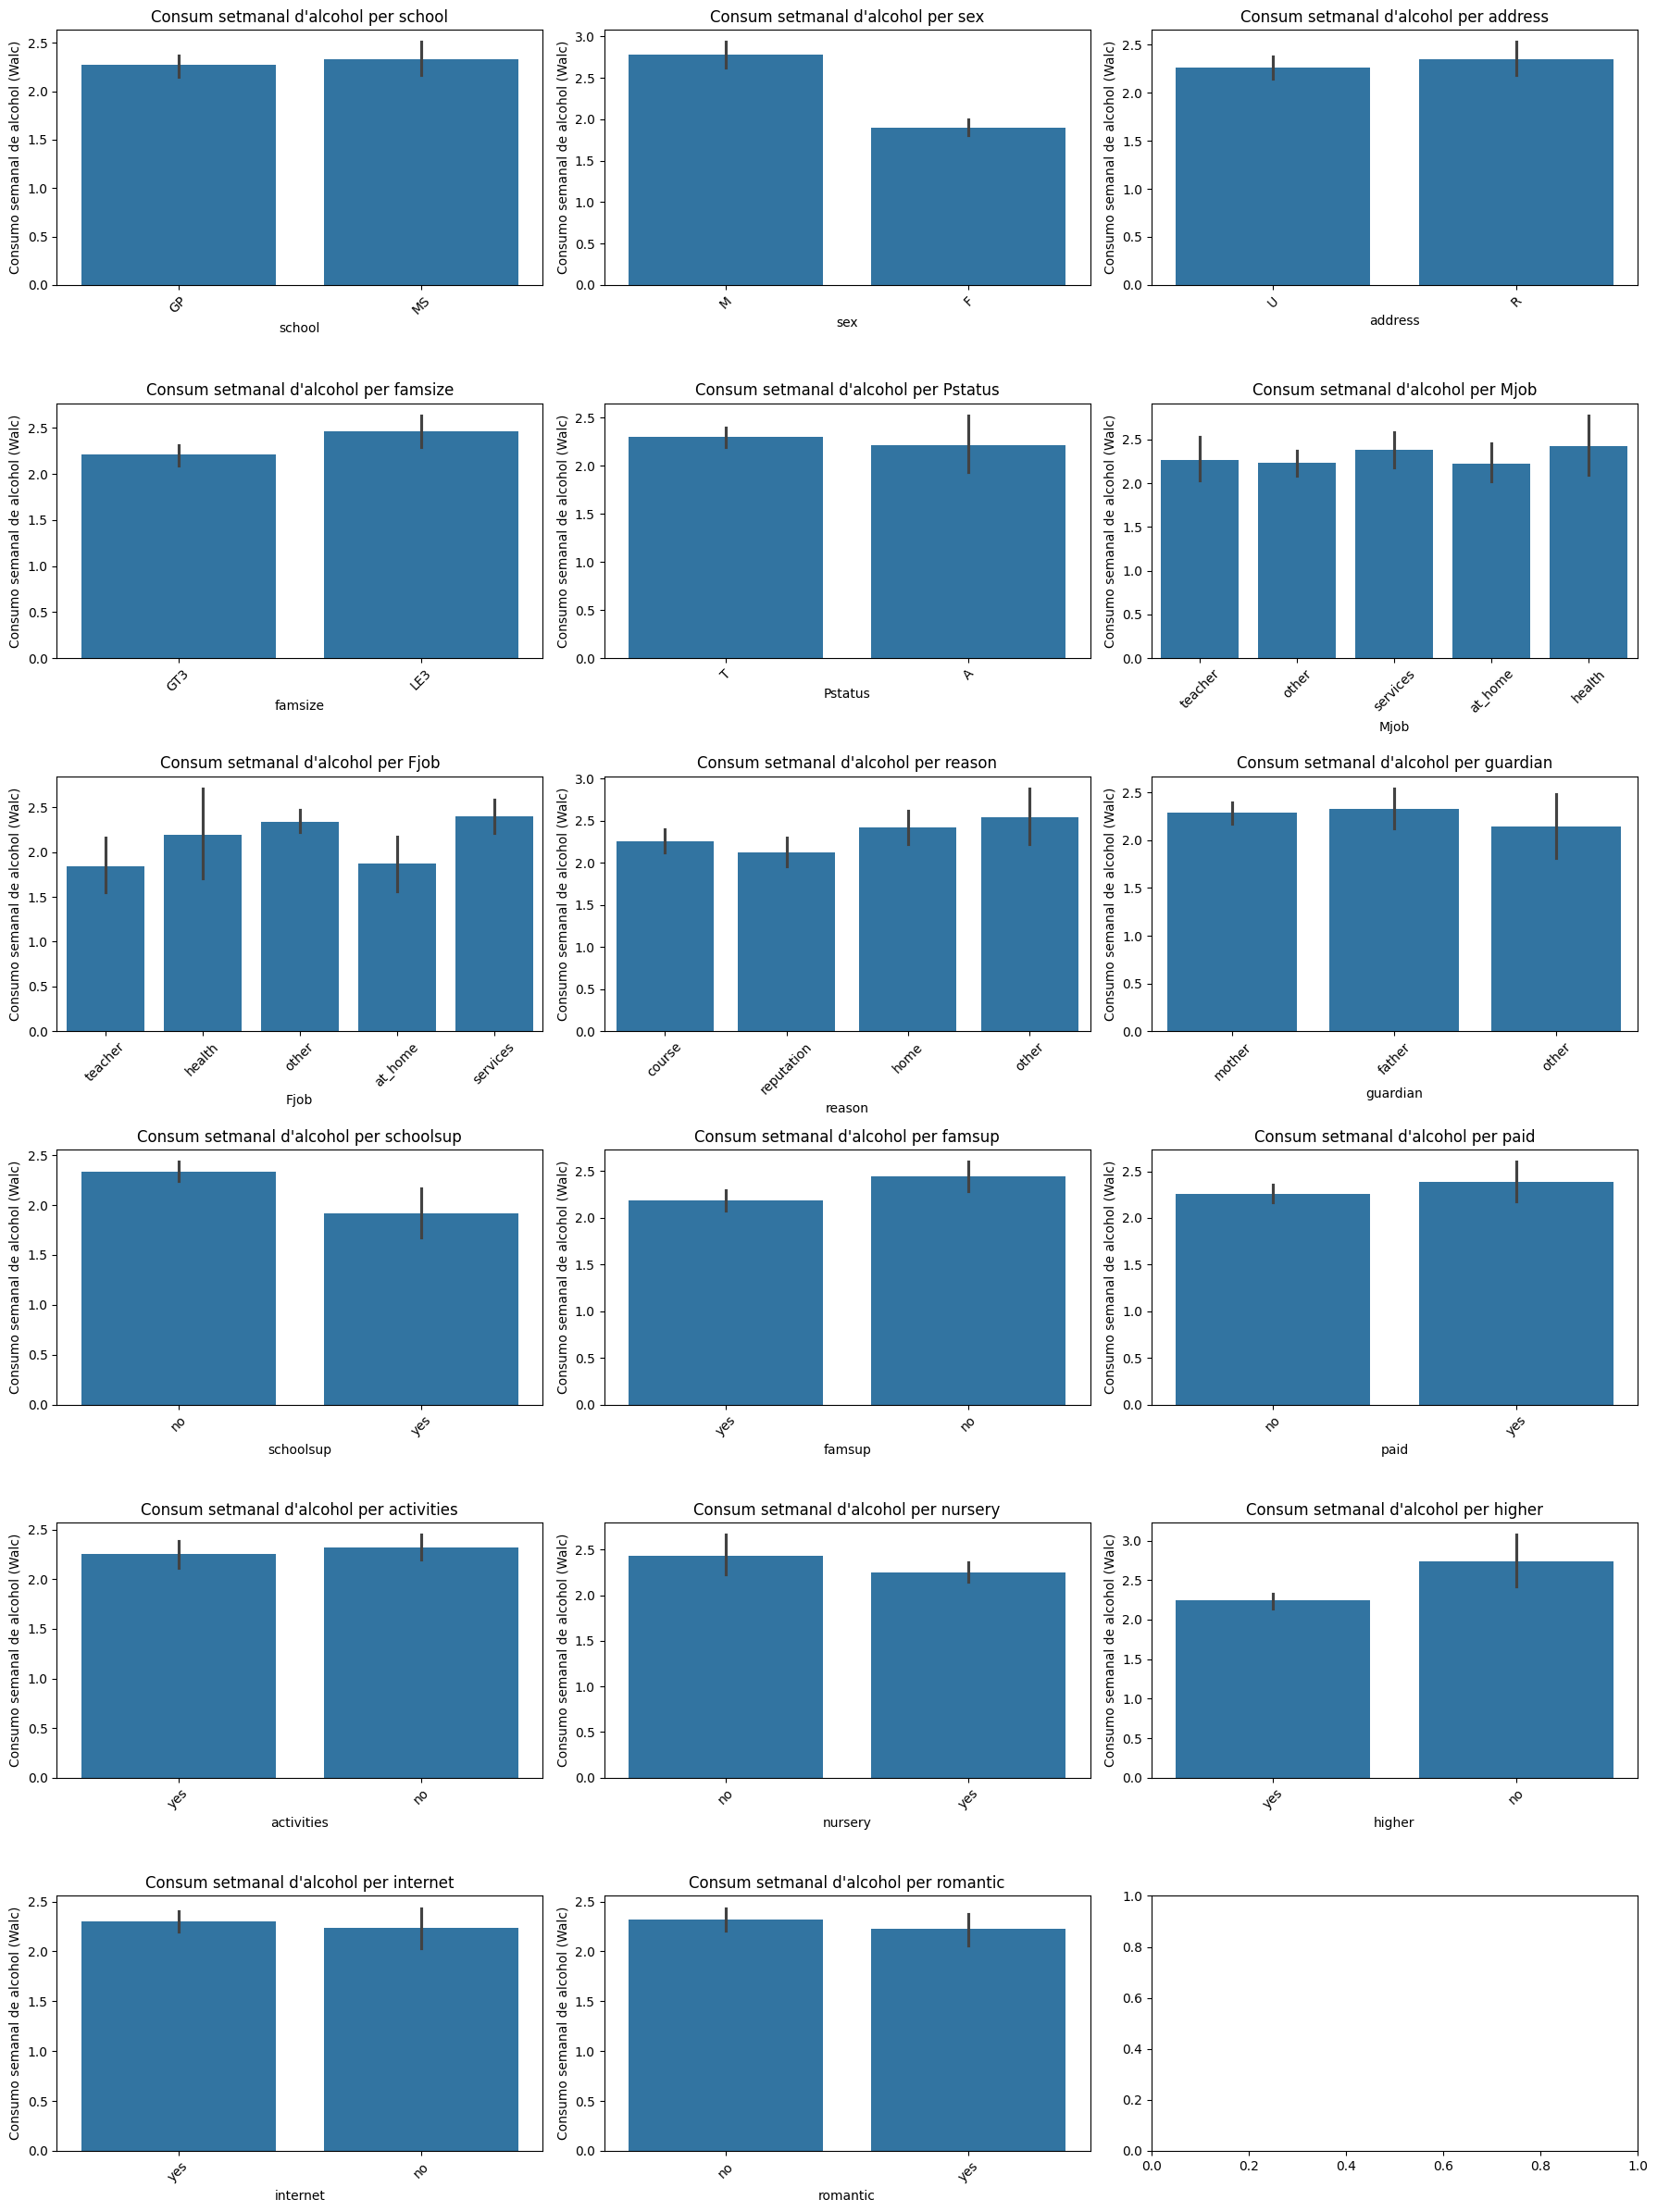

In [777]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables categóricas
categ_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
              'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
              'famsup', 'paid', 'activities', 'nursery', 'higher', 
              'internet', 'romantic']

# Crear los subgráficos
fig, axes = plt.subplots(6, 3, figsize=(18, 24))  # Ajusta el tamaño de la figura si es necesario

# Iterar a través de las variables categóricas
for idx, var in enumerate(categ_vars):
    row, col = divmod(idx, 3)  # Ubicación de cada gráfico
    # Graficar el consumo semanal de alcohol ('Walc') en función de la variable categórica
    sns.barplot(x=var, y='Walc', data=train, ax=axes[row, col])
    axes[row, col].set_title(f'Consum setmanal d\'alcohol per {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Consumo semanal de alcohol (Walc)')
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje x


# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


Pel cas de l'atribut sex, es destaca que els estudiants masculins (M) mostren un consum d'alcohol més elevat en comparació amb les estudiants femenines (F). Aquesta diferència podria estar relacionada amb factors socials o culturals que influeixen en el comportament dels estudiants durant el cap de setmana.

Pel cas de l'atribut famsize, els estudiants amb famílies més petites (LE3, menys o igual a 3 membres) presenten un consum lleugerament superior en comparació amb els de famílies més grans (GT3). Això podria suggerir que els estudiants de famílies petites tenen més llibertat o menys supervisió familiar.

Pel cas de l'atribut Fjob, destaca la categoria de services com la que té un consum setmanal d'alcohol més alt. Això podria indicar que els estudiants amb pares que treballen en serveis estan més exposats a situacions que fomenten el consum d'alcohol, o que l'entorn familiar i socioeconòmic influeix en aquest comportament.

Pel cas de l'atribut schoolsup, aquells estudiants que no reben suport educatiu addicional (no) tendeixen a mostrar un consum més elevat d'alcohol durant el cap de setmana. Aquesta observació pot indicar que els estudiants que necessiten menys suport podrien tenir més temps lliure o menys pressió acadèmica.

Pel cas de l'atribut famsup, els estudiants que no reben suport educatiu de la família (no) presenten un consum lleugerament superior en comparació amb aquells que sí el reben. Això pot reflectir un menor control parental o un entorn familiar menys estructurat.

Pel cas de l'atribut nursery, destaca lleugerament la categoria de no. Els estudiants que no van assistir a l'escola bressol mostren un consum d'alcohol una mica més alt, tot i que la diferència no és molt pronunciada. Això podria estar vinculat a diferents tipus de socialització primerenca.

Pel cas de l'atribut higher, destaca la categoria no amb un consum més elevat. Els estudiants que no tenen intenció de continuar amb estudis superiors tendeixen a consumir més alcohol, la qual cosa pot indicar una actitud més despreocupada cap al futur acadèmic o una menor motivació educativa.

Respecte a les altres que no s'han mencionat, degut a l'equilibri entre les classes dels atributs, no s'han considerat. Ara que ja coneixem la importància de cada característica, procedirem a considerar què fer amb elles, com eliminar les més insignificants o realitzar algun tipus de càlcul conjunt per poder obtenir una nova característica amb més informació.

### 2. Preprocessing

Després d'analitzar el conjunt de dades, hem comprovat que no hi ha valors nuls (NaNs) en cap de les característiques del train. Això facilita considerablement la preparació de les dades. Per tant, podem saltar-nos el procés d'imputació o eliminació de dades mancants.

In [778]:
train_NaN_P = (train.isna().sum() / len(train)) * 100
train_NaN = pd.DataFrame({
    'Número': train.isna().sum(),
    'Percentatge': train_NaN_P
})
print("TRAIN_DATA - Valors nuls:")
print(train_NaN)

TRAIN_DATA - Valors nuls:
            Número  Percentatge
school           0          0.0
sex              0          0.0
age              0          0.0
address          0          0.0
famsize          0          0.0
Pstatus          0          0.0
Medu             0          0.0
Fedu             0          0.0
Mjob             0          0.0
Fjob             0          0.0
reason           0          0.0
guardian         0          0.0
traveltime       0          0.0
studytime        0          0.0
failures         0          0.0
schoolsup        0          0.0
famsup           0          0.0
paid             0          0.0
activities       0          0.0
nursery          0          0.0
higher           0          0.0
internet         0          0.0
romantic         0          0.0
famrel           0          0.0
freetime         0          0.0
goout            0          0.0
Dalc             0          0.0
Walc             0          0.0
health           0          0.0
absences      

Recorden que les hem organitzat a'aquesta manera:

In [779]:
numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

nominal_features = ['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 
                    'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                    'higher', 'internet', 'romantic']

ordinal_features = ['famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                    'famrel', 'freetime', 'goout', 'Dalc', 'health'] #Walc no se codifica

Sent mes especifics:

In [780]:
categorical_binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
                               'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                               'higher', 'internet', 'romantic']

categorical_nominal_features = ['Mjob', 'Fjob', 'reason', 'guardian']

categorical_ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                                'famrel', 'freetime', 'goout', 'Dalc', 'health'] #Walc no se codifica

categorical_numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

He analitzat algunes característiques que semblen aportar poc valor o que tenen poca correlació amb el nostre objectiu, com ara: age, Medu, Fedu, traveltime, failures, health, school, address, pstatus, mjob, fjob, reason, guardian, paid, activities, internet, i romantic. A causa de la seva baixa correlació o poc impacte directe, he decidit eliminar-les o, si és possible, combinar-les per crear noves característiques que siguin més informatives i que puguin tenir un pes més gran en el model.

Per aquest motiu, he creat dues noves característiques que combinen diverses variables que poden tenir un major impacte en el comportament dels estudiants. Aquestes noves característiques són:

academic_index: Aquest índex combina característiques relacionades amb el rendiment acadèmic, com studytime, failures, Medu, Fedu i absences. He assignat pesos a cada variable per reflectir la seva influència percebuda sobre el comportament acadèmic dels estudiants.

social_index: Aquest índex combina variables relacionades amb la vida social dels estudiants, com goout, activities, romantic, internet, i school. Les relacions socials poden tenir un impacte significatiu en el consum d'alcohol, per la qual cosa aquestes variables es combinen per formar un índex més representatiu.

Les funcions per calcular aquests dos índexs són les següents:

In [781]:
# Crear una nova característica: "academic_index"
def calculate_academic_index(row):
    # Pesos basats en la importància percebuda
    study_weight = 2 if row['studytime'] >= 3 else 1
    failure_penalty = row['failures'] * -1  # Penalització per fracassos
    medu_weight = row['Medu'] * 1.5  # Impacte del nivell educatiu de la mare
    fedu_weight = row['Fedu'] * 1.5  # Impacte del nivell educatiu del pare
    absence_penalty = row['absences'] * -0.5  # Penalització per absències
    
    # Índex combinat
    index = study_weight + failure_penalty + medu_weight + fedu_weight + absence_penalty
    return index

# Aplicar la funció al dataset
train['academic_index'] = train.apply(calculate_academic_index, axis=1)
test['academic_index'] = test.apply(calculate_academic_index, axis=1)

# Crear una nova característica: "social_index"
def calculate_social_index(row):
    # Pesos basats en la importància percebuda
    goout_weight = row['goout'] * 1.5
    activity_bonus = 1 if row['activities'] == 'yes' else 0
    romantic_bonus = 1 if row['romantic'] == 'yes' else 0
    internet_bonus = 1 if row['internet'] == 'yes' else 0
    school_weight = 1 if row['school'] == 'GP' else 0
    
    # Índex combinat
    index = goout_weight + activity_bonus + romantic_bonus + internet_bonus + school_weight
    return index

# Aplicar la funció al dataset
train['social_index'] = train.apply(calculate_social_index, axis=1)
test['social_index'] = test.apply(calculate_social_index, axis=1)


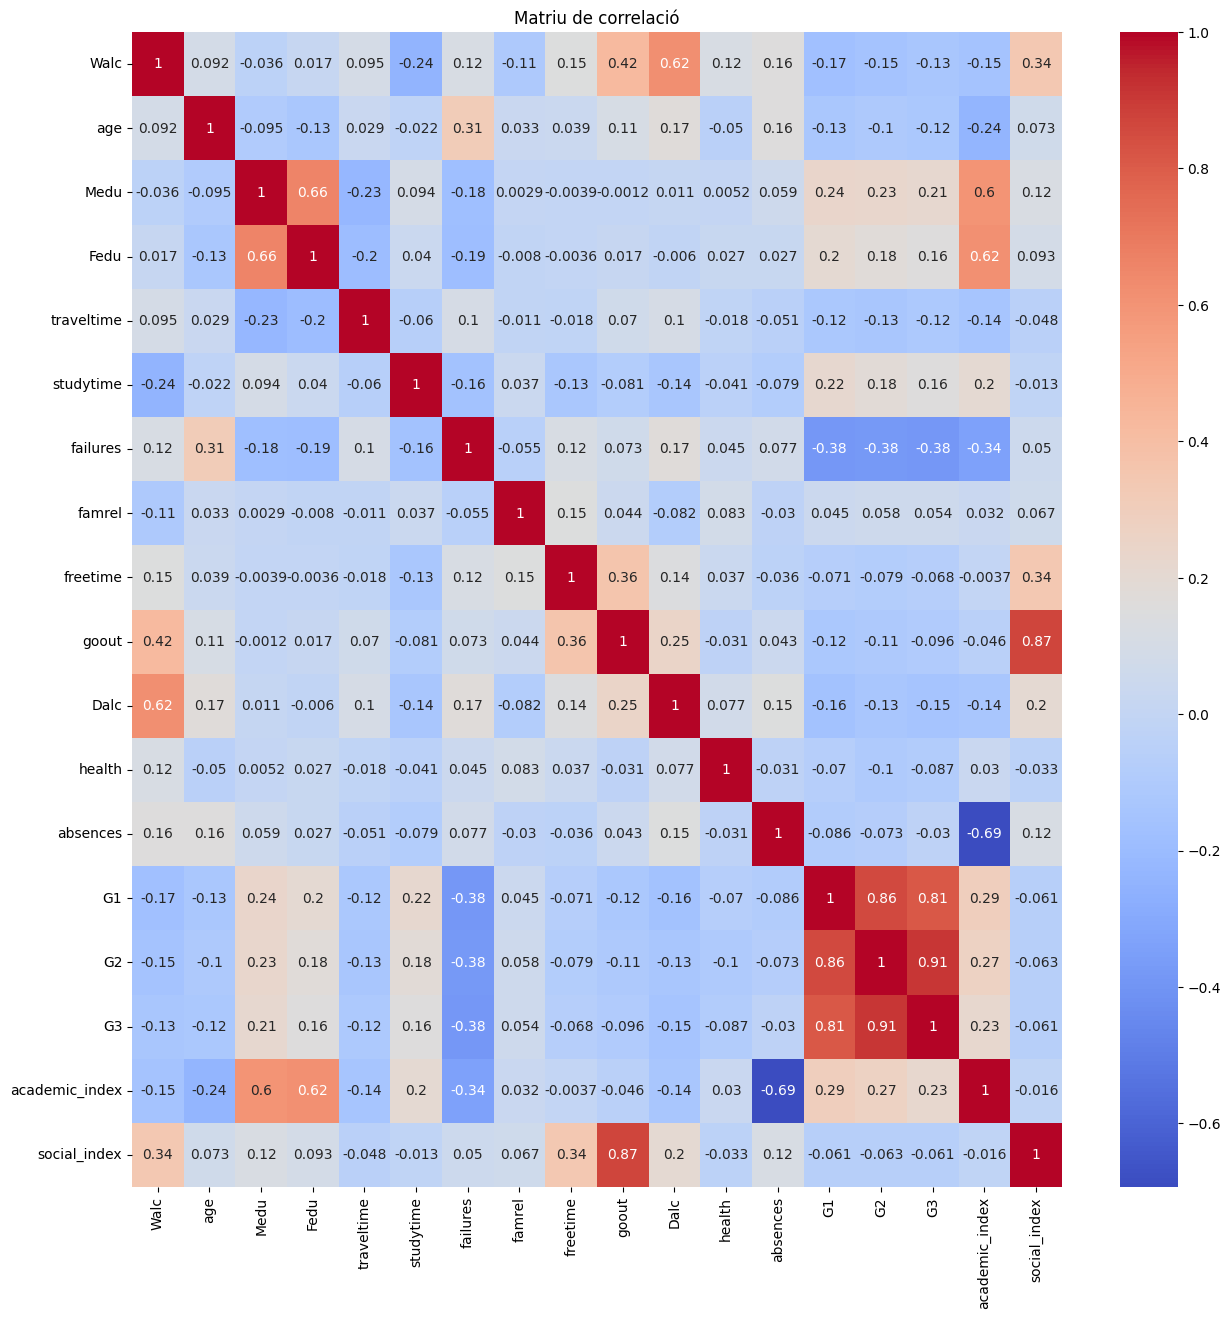

In [782]:
nume_features = ['Walc', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health', 'absences', 'G1', 'G2', 'G3', 'academic_index', 'social_index']
corr_matrix = train[nume_features].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()

Per eliminar les característiques que hem considerat poc útils, podem utilitzar el següent codi per "dropear" les columnes del dataset:

In [783]:
# Dropear les característiques que considerem poc útils
columns_to_drop = ['Medu', 'Fedu', 'school', 'address', 
                   'Pstatus', 'paid', 'activities', 'internet', 'romantic']

train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)


DesprÈs d'eliminar les caracteristiques quedarien de la seguien manera:


In [784]:
categorical_binary_features = ['sex', 'famsize', 'schoolsup', 'famsup', 
                               'nursery', 'higher']

categorical_nominal_features = ['Mjob', 'Fjob', 'reason', 'guardian']

categorical_ordinal_features = ['traveltime', 'studytime', 'failures', 
                                'famrel', 'freetime', 'goout', 'Dalc', 
                                'health'] #Walc no se codifica

categorical_numerical_features = ['age', 'absences', 'G1', 'G2', 'G3', 
                                  'academic_index', 'social_index']

Descripció de la codificació de les característiques:

Variables categòriques (binàries i nominales):

Les variables categòriques són aquelles que no tenen un ordre intrínsec, i es poden classificar en dos tipus: binàries i nominales.

Variables binàries: Aquestes variables només tenen dues categories possibles, per exemple: school, sex, famsize, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic. Per a aquestes variables utilitzem un LabelEncoder, ja que es poden codificar simplement assignant un valor numèric (0 o 1) a cada categoria.

Variables nominals: Són aquelles que tenen més de dues categories, com Mjob, Fjob, reason, guardian. Aquestes variables no tenen un ordre implícit entre les categories, per tant, la millor opció per codificar-les és el OneHotEncoder, que crea una columna binària per cada categoria possible.

Variables ordinals:

Les variables ordinals tenen un ordre implícit entre les seves categories. Exemple d'aquestes variables són studytime, failures, traveltime, famrel, freetime, goout, Dalc, health. Aquestes variables s'han de codificar de manera que es mantingui l'ordre entre les categories. Per això, podem utilitzar el OrdinalEncoder, que assigna valors numèrics a les categories seguint el seu ordre implícit.

Variables numèriques:

Les variables numèriques, com age, absences, G1, G2, G3, academic_social_index, no requereixen codificació, però depenent del model, podrien necessitar normalització o estandardització.

Com hem eliminar algunes no les considerarem en la codificacio como es d'esperar.

Codificació binària: Per a les variables binàries, utilitzem OrdinalEncoder, que assigna valors numèrics de 0 o 1. S'ajusta i transforma el conjunt d'entrenament i després es transforma el conjunt de prova amb el mateix encoder.

In [785]:
# ---------------------- Binary Encoding ----------------------
binary_encoder = OrdinalEncoder()

# Ajustar y transformar para el conjunto de entrenamiento
train[categorical_binary_features] = binary_encoder.fit_transform(train[categorical_binary_features])

# Transformar para el conjunto de prueba
test[categorical_binary_features] = binary_encoder.transform(test[categorical_binary_features])

Codificació One-Hot: Per a les variables nominals, utilitzem OneHotEncoder per crear noves columnes, una per cada categoria. L'encoder s'ajusta i transforma el conjunt d'entrenament, i després només es transforma el conjunt de prova.

In [786]:
# ---------------------- One-Hot Encoding ----------------------
one_hot_encoder = ce.OneHotEncoder(cols=categorical_nominal_features, use_cat_names=True)

# Codificación One-Hot para el conjunto de entrenamiento
train = one_hot_encoder.fit_transform(train)

# Codificación One-Hot para el conjunto de prueba (solo transformando)
test = one_hot_encoder.transform(test)

Codificació ordinal: Per a les variables ordinals, utilitzem OrdinalEncoder, que manté l'ordre intrínsec de les categories. L'encoder s'ajusta i transforma el conjunt d'entrenament, i després es transforma el conjunt de prova.

In [787]:
# ---------------------- Ordinal Encoding ----------------------
ordinal_encoder = OrdinalEncoder()

# Ajustar y transformar para el conjunto de entrenamiento
train[categorical_ordinal_features] = ordinal_encoder.fit_transform(train[categorical_ordinal_features])

# Transformar para el conjunto de prueba
test[categorical_ordinal_features] = ordinal_encoder.transform(test[categorical_ordinal_features])


train.head(10)

,sex,age,famsize,Mjob_teacher,Mjob_other,Mjob_services,Mjob_at_home,Mjob_health,Fjob_teacher,Fjob_health,...,goout,Dalc,Walc,health,absences,G1,G2,G3,academic_index,social_index
652,1.0,17,0.0,1,0,0,0,0,1,0,...,0.0,0.0,2,4.0,6,10,8,9,10.0,4.5
57,1.0,15,0.0,1,0,0,0,0,0,1,...,1.0,0.0,1,4.0,4,14,15,15,11.0,5.0
108,1.0,15,0.0,0,1,0,0,0,0,0,...,4.0,2.0,5,0.0,6,10,13,13,11.0,11.5
96,1.0,16,0.0,0,0,1,0,0,0,0,...,2.0,0.0,1,3.0,2,11,15,15,10.5,7.5
275,0.0,17,1.0,0,0,1,0,0,0,0,...,3.0,1.0,3,4.0,6,12,12,12,4.0,9.0
324,0.0,17,1.0,0,0,0,1,0,0,0,...,2.0,1.0,3,1.0,0,16,15,15,5.0,6.5
980,0.0,17,1.0,0,1,0,0,0,0,0,...,2.0,1.0,2,2.0,5,8,7,8,5.5,4.5
21,1.0,15,0.0,0,0,0,0,1,0,1,...,1.0,0.0,1,4.0,0,12,15,15,13.0,5.0
255,1.0,17,1.0,0,0,0,0,1,0,0,...,3.0,0.0,2,4.0,2,7,9,8,2.0,9.0
706,0.0,19,0.0,0,1,0,0,0,0,0,...,4.0,2.0,3,4.0,16,11,12,12,2.0,10.5


Explicació de la normalització i per què s'ha escollit MinMaxScaler:

En primer lloc, hem aplicat una normalització a les variables numèriques utilitzant el MinMaxScaler. Aquesta tècnica transforma les variables numèriques perquè estiguin en un rang de [0, 1], mantenint la seva relació proporcional original. L'objectiu és assegurar-nos que totes les variables tinguin la mateixa escala, ja que alguns algoritmes de machine learning (com els basats en distàncies, per exemple KNN o SVM) poden veure's afectats per les diferents escales de les variables.

Aquesta elecció de MinMaxScaler en particular es justifica perquè, en el nostre conjunt de dades, les variables numèriques com age, absences, G1, G2, G3, i academic_social_index poden tenir valors amb diferent rang (per exemple, age pot tenir valors entre 0 i 100, mentre que G1, G2, G3 pot estar entre 0 i 20). Al normalitzar-les, aconseguim que el model no es vegi influenciat per aquesta diferència de magnitud, ajudant-lo a convergir més ràpidament i a ser més precís en el seu aprenentatge.

Procés de normalització:

Ajustem el MinMaxScaler al conjunt d'entrenament (utilitzant fit), per tal d'obtenir el mínim i màxim de cada variable numèrica.
Transformem tant el conjunt d'entrenament com el de prova per aplicar aquesta normalització a les dades, mantenint la coherència entre ambdós conjunts.

In [788]:
# ---------------------- Normalització per MinMaxScaler ----------------------
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train[categorical_numerical_features])

train[categorical_numerical_features] = min_max_scaler.transform(train[categorical_numerical_features])
test[categorical_numerical_features] = min_max_scaler.transform(test[categorical_numerical_features])

# ---------------------- Guarden el prepocessing ----------------------

train.to_csv('PreprocessingDoneTrain.csv', index=False)
test.to_csv('PreprocessingDoneTest.csv', index=False)

train.head(10)

,sex,age,famsize,Mjob_teacher,Mjob_other,Mjob_services,Mjob_at_home,Mjob_health,Fjob_teacher,Fjob_health,...,goout,Dalc,Walc,health,absences,G1,G2,G3,academic_index,social_index
652,1.0,0.285714,0.0,1,0,0,0,0,1,0,...,0.0,0.0,2,4.0,0.080000,0.400000,0.421053,0.45,0.906977,0.30
57,1.0,0.000000,0.0,1,0,0,0,0,0,1,...,1.0,0.0,1,4.0,0.053333,0.666667,0.789474,0.75,0.930233,0.35
108,1.0,0.000000,0.0,0,1,0,0,0,0,0,...,4.0,2.0,5,0.0,0.080000,0.400000,0.684211,0.65,0.930233,1.00
96,1.0,0.142857,0.0,0,0,1,0,0,0,0,...,2.0,0.0,1,3.0,0.026667,0.466667,0.789474,0.75,0.918605,0.60
275,0.0,0.285714,1.0,0,0,1,0,0,0,0,...,3.0,1.0,3,4.0,0.080000,0.533333,0.631579,0.60,0.767442,0.75
324,0.0,0.285714,1.0,0,0,0,1,0,0,0,...,2.0,1.0,3,1.0,0.000000,0.800000,0.789474,0.75,0.790698,0.50
980,0.0,0.285714,1.0,0,1,0,0,0,0,0,...,2.0,1.0,2,2.0,0.066667,0.266667,0.368421,0.40,0.802326,0.30
21,1.0,0.000000,0.0,0,0,0,0,1,0,1,...,1.0,0.0,1,4.0,0.000000,0.533333,0.789474,0.75,0.976744,0.35
255,1.0,0.285714,1.0,0,0,0,0,1,0,0,...,3.0,0.0,2,4.0,0.026667,0.200000,0.473684,0.40,0.720930,0.75
706,0.0,0.571429,0.0,0,1,0,0,0,0,0,...,4.0,2.0,3,4.0,0.213333,0.466667,0.631579,0.60,0.720930,0.90


Observem la matriu de correlacio:

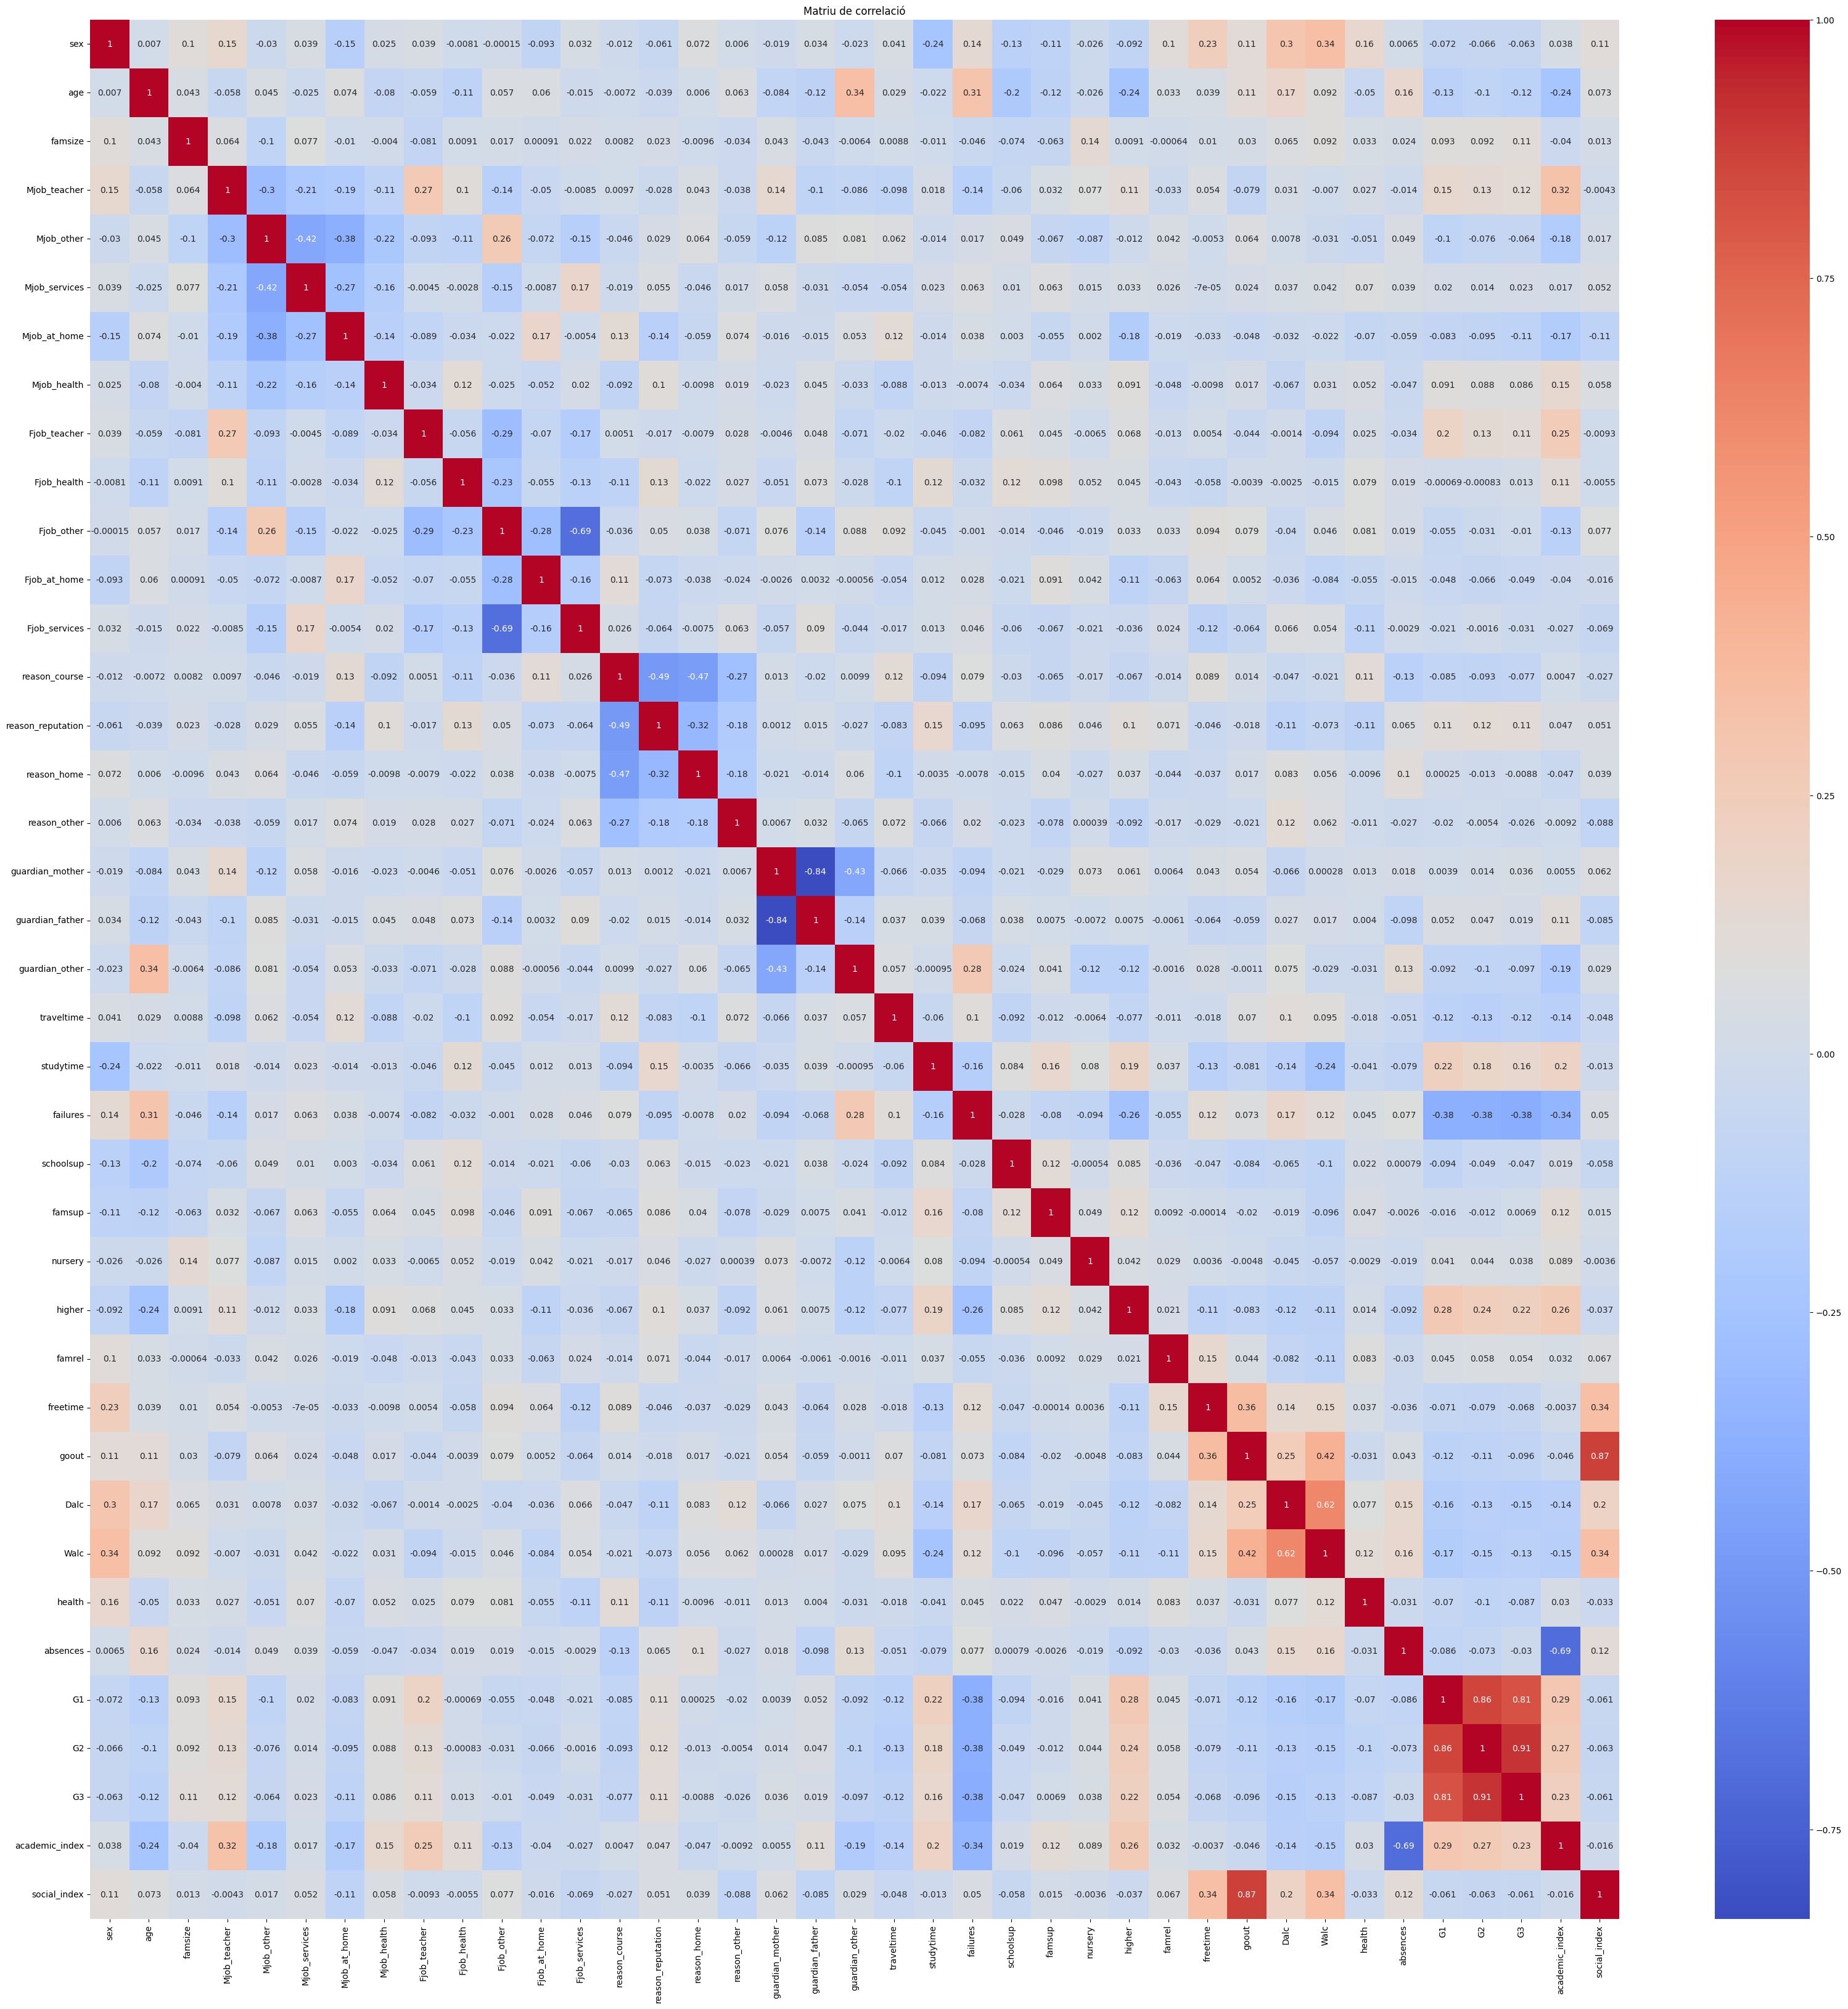

In [789]:
plt.figure(figsize=(40, 40))
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()

### 3. Metric selection

In [790]:
################################ CORVA PR ################################
def plot_pr_curve(y_pred, lr_probs):
    lr_precision, lr_recall,_ = precision_recall_curve(y_pred, lr_probs)
    lr_auc = auc(lr_recall, lr_precision)
    print('El nostre model té una auc=%.3f' % (lr_auc))
    no_skill = len(y_pred[y_pred==1]) / len(y_pred)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sense capacitat predictiva')
    plt.plot(lr_recall, lr_precision, marker='.', label='Nostre')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show() 

In [791]:
X = train.drop('Walc', axis=1)
y = train['Walc']
X_test = test.drop('Walc', axis=1)
y_test = test['Walc']

print("Informació de cada atribut:")
print(X.info())
print("El nombre de mostres que tenim al train és de", train.shape[0])
print("El nombre de atributs que tenim al train és de", train.shape[1])
print(X_test.info())
print("El nombre de mostres que tenim al test és de", test.shape[0])
print("El nombre de atributs que tenim al test és de", test.shape[1])

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 652 to 346
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                730 non-null    float64
 1   age                730 non-null    float64
 2   famsize            730 non-null    float64
 3   Mjob_teacher       730 non-null    int64  
 4   Mjob_other         730 non-null    int64  
 5   Mjob_services      730 non-null    int64  
 6   Mjob_at_home       730 non-null    int64  
 7   Mjob_health        730 non-null    int64  
 8   Fjob_teacher       730 non-null    int64  
 9   Fjob_health        730 non-null    int64  
 10  Fjob_other         730 non-null    int64  
 11  Fjob_at_home       730 non-null    int64  
 12  Fjob_services      730 non-null    int64  
 13  reason_course      730 non-null    int64  
 14  reason_reputation  730 non-null    int64  
 15  reason_home        730 non-null    int64  
 16  r

In [792]:

# Suponiendo que ya tienes los datos X (características) y y (etiquetas) correctamente definidos
categorical_features = [3, 19]  # Asegúrate de que estos índices sean correctos

# Ajustar la estrategia de balanceo para cada clase según el número de muestras originales
sampling_strategy = {1: 450, 2: 440, 3: 430, 4: 420, 5: 410}

# Crear la instancia de SMOTE
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42, sampling_strategy=sampling_strategy)

# Aplicar SMOTE al conjunto de datos
X, y = smote_nc.fit_resample(X, y)

# Guardar X_res (características) y y_res (etiquetas) en archivos CSV
X.to_csv('PreprocessingDoneTrain.csv', index=False)
y.to_frame().to_csv('PreprocessingDoneTest.csv', index=False)  # Corregido para guardar y


Walc
1    450
2    440
3    430
4    420
5    410
Name: count, dtype: int64


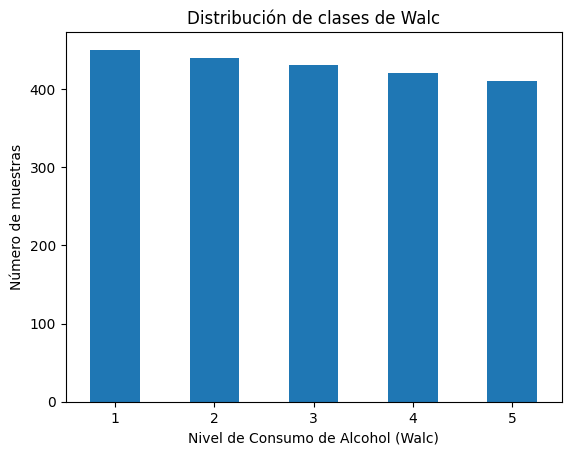

In [793]:
# Contar el número de instancias de cada clase en 'Walc'
counts = y.value_counts()

# Mostrar los resultados
print(counts)

# Graficar la distribución de las clases en 'Walc'
counts.plot(kind='bar')
plt.title('Distribución de clases de Walc')
plt.xlabel('Nivel de Consumo de Alcohol (Walc)')
plt.ylabel('Número de muestras')
plt.xticks(rotation=0)  # Para que las etiquetas de las barras se vean bien
plt.show()

In [794]:
# CROSS-VALIDATION DE LOGISTIC REGRESSION
model = LogisticRegression(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
lg_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("LogisticRegression:")
print(f"Scores en cada fold: {lg_scores}")
print(f"Media del score: {lg_scores.mean()}")

# CROSS-VALIDATION DE KNN
model = KNeighborsClassifier()
stratified_kfold = StratifiedKFold()
knn_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nKNeighborsClassifier:")
print(f"Scores en cada fold: {knn_scores}")
print(f"Media del score: {knn_scores.mean()}")

# CROSS-VALIDATION DE DECISION TREE CLASSIFIER
model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
dt_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nDecisionTreeClassifier:")
print(f"Scores en cada fold: {dt_scores}")
print(f"Media del score: {dt_scores.mean()}")

# CROSS-VALIDATION DE RANDOM FOREST CLASSIFIER
model = RandomForestClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
rf_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nRandomForestClassifier:")
print(f"Scores en cada fold: {rf_scores}")
print(f"Media del score: {rf_scores.mean()}")

# CROSS-VALIDATION DE ADA BOOST CLASSIFIER AMB DECISION TREE CLASSIFIER
model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0), random_state=0)
stratified_kfold = StratifiedKFold()
ab_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nAdaBoostClassifier:")
print(f"Scores en cada fold: {ab_scores}")
print(f"Media del score: {ab_scores.mean()}")

# CROSS-VALIDATION DE SUPER VECTOR CLASSIFIER
model = SVC(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
svc_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print("\nSVC:")
print(f"Scores en cada fold: {svc_scores}")
print(f"Media del score: {svc_scores.mean()}")

LogisticRegression:
Scores en cada fold: [0.51928588 0.59215936 0.62728454 0.61841567 0.61715568]
Media del score: 0.594860225583264

KNeighborsClassifier:
Scores en cada fold: [0.83683765 0.85948392 0.87184052 0.94301983 0.93740024]
Media del score: 0.889716431704362

DecisionTreeClassifier:
Scores en cada fold: [0.71531783 0.77734402 0.7550466  0.82543913 0.82195218]
Media del score: 0.7790199512845142

RandomForestClassifier:
Scores en cada fold: [0.8785701  0.88843298 0.95192055 0.98382388 0.9676531 ]
Media del score: 0.9340801195255046

AdaBoostClassifier:
Scores en cada fold: [0.71416229 0.76700807 0.76727929 0.8223257  0.82409949]
Media del score: 0.7789749658326577

SVC:
Scores en cada fold: [0.64921572 0.70641529 0.76038957 0.77263466 0.7312543 ]
Media del score: 0.723981908685937


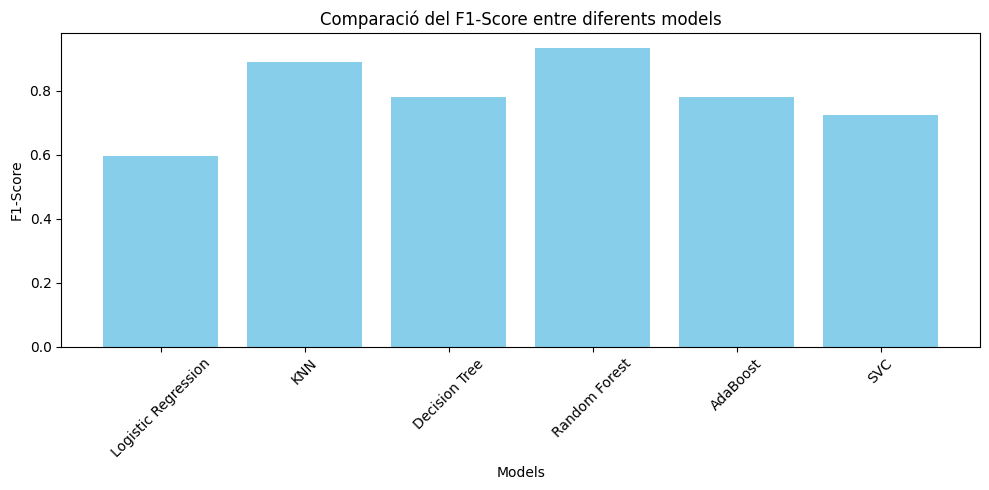

In [795]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'SVC']
f1_means = [lg_scores.mean(), knn_scores.mean(), dt_scores.mean(), rf_scores.mean(), ab_scores.mean(), svc_scores.mean()]

plt.figure(figsize=(10, 5))
plt.bar(models, f1_means, color='skyblue')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Comparació del F1-Score entre diferents models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [796]:
# GRID SEARCH DE LOGISTIC REGRESSION
print(f'LOGISTIC REGRESSION')
param_grid_lr = dict(
    C=[0.01, 0.1, 1, 10],  # Rango más moderado
    solver=['lbfgs', 'liblinear'],  # 'saga' solo es útil con datasets muy grandes o regulares
    max_iter=[100, 200],
    tol=[1e-4]
)

lr_model = LogisticRegression(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_lr = GridSearchCV(lr_model, param_grid_lr, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_lr.fit(X, y)
lr_scores = grid_lr.best_score_
print(f'Millors parametres: {grid_lr.best_params_}')
print(f'Millor F1: {round(grid_lr.best_score_, 5)}')

# GRID SEARCH DE KNN
print(f'KNN')
param_grid_knn = dict(
    n_neighbors=[3, 5, 7, 9],  # Limitar vecinos para evitar modelos extremos
    weights=['uniform', 'distance'],
    metric=['euclidean', 'manhattan']
)

knn_model = KNeighborsClassifier()
stratified_kfold = StratifiedKFold()
grid_knn = GridSearchCV(knn_model, param_grid_knn, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_knn.fit(X, y)
knn_scores = grid_knn.best_score_
print(f'Millors parametres: {grid_knn.best_params_}')
print(f'Millor F1: {round(grid_knn.best_score_, 5)}')

# GRID SEARCH DE DECISION TREE CLASSIFIER
print(f'DECISION TREE CLASSIFIER')
param_grid_dt = dict(
    max_depth=[2, 4, 6],  # Profundidad limitada para evitar sobreajuste
    criterion=['gini', 'entropy'],
    min_samples_split=[2, 5, 10]  # Controlar cuándo dividir nodos
)

dt_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_dt = GridSearchCV(dt_model, param_grid_dt, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_dt.fit(X, y)
dt_scores = grid_dt.best_score_
print(f'Millors parametres: {grid_dt.best_params_}')
print(f'Millor F1: {round(grid_dt.best_score_, 5)}')

# GRID SEARCH DE RANDOM FOREST CLASSIFIER
print(f'RANDOM FOREST CLASSIFIER')
param_grid_rf = dict(
    n_estimators=[50, 100, 150],  # Ampliar número de árboles
    max_depth=[2, 4, 6],
    min_samples_split=[2, 5]  # Requerir más ejemplos por división
)

rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_rf.fit(X, y)
rf_scores = grid_rf.best_score_
print(f'Millors parametres: {grid_rf.best_params_}')
print(f'Millor F1: {round(grid_rf.best_score_, 5)}')

# CROSS-VALIDATION DE ADA BOOST CLASSIFIER AMB DECISION TREE CLASSIFIER
print(f'ADA BOOST CLASSIFIER')
param_grid_ab = dict(
    n_estimators=[50, 75, 100],  # Número razonable de estimadores
    learning_rate=[0.01, 0.1]  # Evitar valores altos que pueden causar inestabilidad
)

ab_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=0), algorithm='SAMME', random_state=0)
stratified_kfold = StratifiedKFold()
grid_ab = GridSearchCV(estimator=ab_model, param_grid=param_grid_ab, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_ab.fit(X, y)
ab_scores = grid_ab.best_score_
print(f'Millors parametres: {grid_ab.best_params_}')
print(f'Millor F1: {round(grid_ab.best_score_, 5)}')

# GRID SEARCH DE SUPER VECTOR CLASSIFIER
print(f'SUPER VECTOR CLASSIFIER')
param_grid_svc = dict(
    C=[0.1, 1, 10],  # Rango moderado para evitar modelos rígidos
    kernel=['linear', 'rbf'],  # Polinomios suelen ser más propensos al sobreajuste
    gamma=['scale'],
)

svc_model = SVC(probability=True, random_state=0, class_weight='balanced')
stratified_kfold = StratifiedKFold()
grid_svc = GridSearchCV(svc_model, param_grid_svc, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1, error_score=np.nan)
grid_svc.fit(X, y)
svc_scores = grid_svc.best_score_
print(f'Millors parametres: {grid_svc.best_params_}')
print(f'Millor F1: {round(grid_svc.best_score_, 5)}')


LOGISTIC REGRESSION


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Millors parametres: {'C': 10, 'max_iter': 200, 'solver': 'lbfgs', 'tol': 0.0001}
Millor F1: 0.60648
KNN
Millors parametres: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Millor F1: 0.94472
DECISION TREE CLASSIFIER
Millors parametres: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2}
Millor F1: 0.62957
RANDOM FOREST CLASSIFIER
Millors parametres: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 100}
Millor F1: 0.75768
ADA BOOST CLASSIFIER
Millors parametres: {'learning_rate': 0.1, 'n_estimators': 100}
Millor F1: 0.86508
SUPER VECTOR CLASSIFIER
Millors parametres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Millor F1: 0.88377


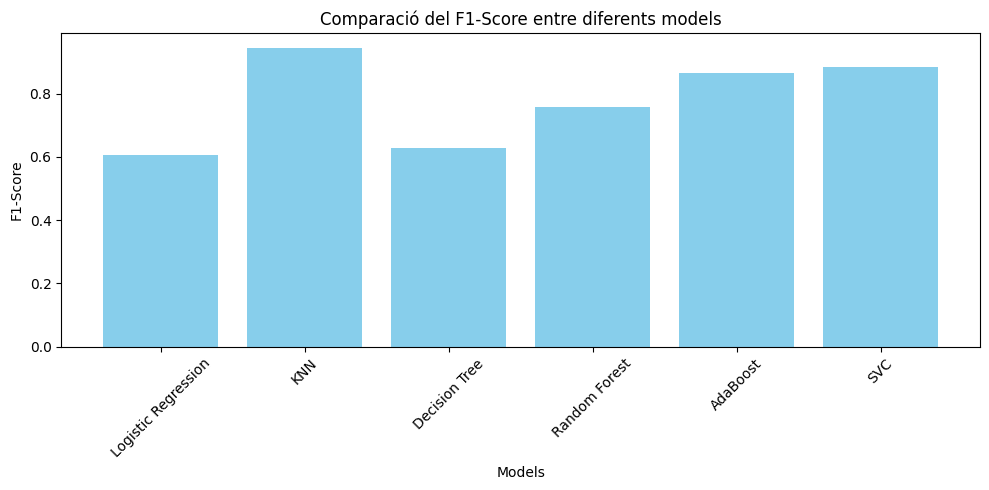

In [797]:
# Modelos y sus F1-scores
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'SVC']
f1_score = [lr_scores, knn_scores, dt_scores, rf_scores, ab_scores , svc_scores]

# Crear gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(models, f1_score, color='skyblue')

# Añadir etiquetas y título
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('Comparació del F1-Score entre diferents models')

# Ajustar el diseño
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()



Model: Logistic Regression
Diferencia final entre entrenamiento y validación: 0.0403
Puntuación final de validación: 0.6065

Model: KNN
Diferencia final entre entrenamiento y validación: 0.0553
Puntuación final de validación: 0.9447

Model: Decision Tree
Diferencia final entre entrenamiento y validación: 0.0818
Puntuación final de validación: 0.6296

Model: Random Forest
Diferencia final entre entrenamiento y validación: 0.1162
Puntuación final de validación: 0.7577

Model: AdaBoost
Diferencia final entre entrenamiento y validación: 0.1312
Puntuación final de validación: 0.8651

Model: SVC
Diferencia final entre entrenamiento y validación: 0.0707
Puntuación final de validación: 0.8838


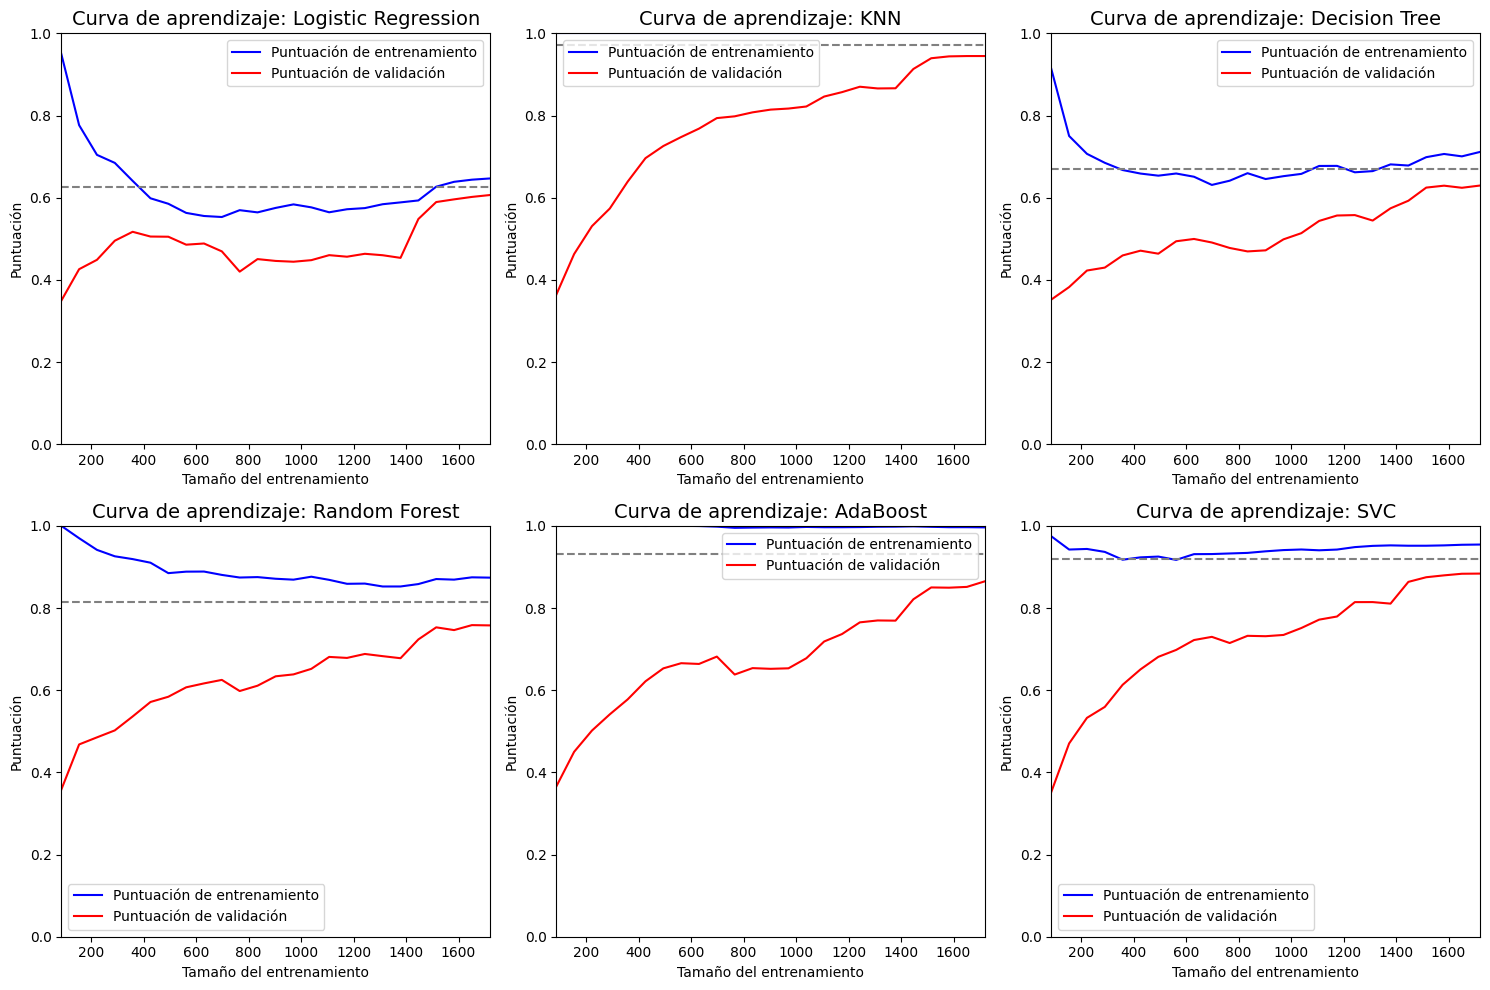

In [798]:
def evaluate_and_plot_learning_curves(models, model_names, X, y):
    # Configura la figura con 2 filas y 3 columnas
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs = axs.ravel()  # Aplana la matriz de ejes

    stratified_kfold = StratifiedKFold()

    for idx, model in enumerate(models):
        name = model_names[idx]
        print(f"\nModel: {name}")
        
        # Calcular la curva de aprendizaje
        N, train_lc, val_lc = learning_curve(
            model, X, y, cv=stratified_kfold,
            train_sizes=np.linspace(0.05, 1, 25),
            n_jobs=-1,
            scoring='f1_macro'
        )
        
        # Promedios de las puntuaciones de entrenamiento y validación
        mean_train_score = np.mean(train_lc, axis=1)
        mean_val_score = np.mean(val_lc, axis=1)
        
        # Graficar la curva de entrenamiento
        axs[idx].plot(N, mean_train_score, color='blue', label='Puntuación de entrenamiento')
        
        # Graficar la curva de validación
        axs[idx].plot(N, mean_val_score, color='red', label='Puntuación de validación')
        
        # Línea horizontal de referencia
        axs[idx].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')
        
        # Configuración de los ejes y las etiquetas
        axs[idx].set_ylim(0, 1)
        axs[idx].set_xlim(N[0], N[-1])
        axs[idx].set_xlabel('Tamaño del entrenamiento')
        axs[idx].set_ylabel('Puntuación')
        axs[idx].set_title(f'Curva de aprendizaje: {name}', size=14)
        axs[idx].legend(loc='best')

        # Calcular la diferencia final entre entrenamiento y validación
        final_train_score = mean_train_score[-1]
        final_val_score = mean_val_score[-1]
        difference_final = final_train_score - final_val_score
        
        # Calcular la puntuación de validación final
        validation_score = final_val_score
        
        # Mostrar los resultados
        print(f"Diferencia final entre entrenamiento y validación: {difference_final:.4f}")
        print(f"Puntuación final de validación: {validation_score:.4f}")

    plt.tight_layout()  # Ajustar el layout
    plt.show()

# Llamar la función con los modelos y sus nombres
models = [grid_lr.best_estimator_, grid_knn.best_estimator_, grid_dt.best_estimator_, grid_rf.best_estimator_, grid_ab.best_estimator_, grid_svc.best_estimator_]
model_names = ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "AdaBoost", "SVC"]
evaluate_and_plot_learning_curves(models, model_names, X, y)


Matriz de Confusión:
 [[86 20 11  2  1]
 [26 25 15  3  2]
 [19  9 18  9  5]
 [ 6  3  9 18  5]
 [ 2  1  1  2 16]]


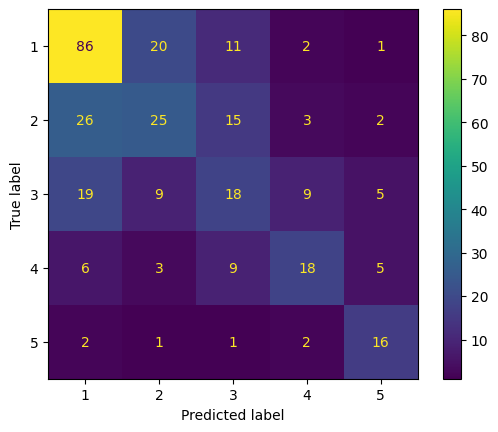

In [799]:
modelo = LogisticRegression(
    C=1000,
    max_iter=300,
    solver='lbfgs',
    tol=0.0001,
    random_state=42
)

model.fit(X, y)
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()

print("Matriz de Confusión:\n", conf_matrix)

In [800]:
# Evaluar en entrenamiento y prueba
train_score = model.score(X, y)
test_score = model.score(X_test, y_test)

print(f'Precisión en entrenamiento: {train_score}')
print(f'Precisión en prueba: {test_score}')

# Si la diferencia es significativa, hay overfitting
if train_score - test_score > 0.1:
    print("Posible overfitting.")


Precisión en entrenamiento: 0.7865116279069767
Precisión en prueba: 0.5191082802547771
Posible overfitting.


### 5.Analisi Final

AUC para la clase 0: 0.500
AUC para la clase 1: 0.235
AUC para la clase 2: 0.183
AUC para la clase 3: 0.160
AUC para la clase 4: 0.171


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


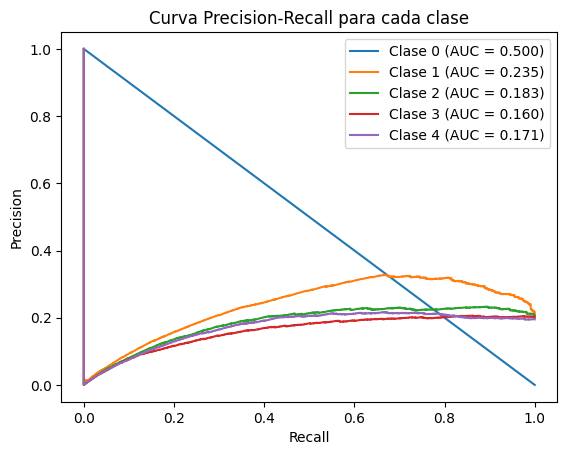

In [801]:
# Entrenamiento del modelo
model = SVC(C=100, gamma=0.1,kernel='rbf', probability=True, random_state=0, class_weight='balanced')
model.fit(X, y)

# Realizamos la validación cruzada para obtener las probabilidades
stratified_kfold = StratifiedKFold()
y_probs = cross_val_predict(model, X, y, cv=stratified_kfold, method='predict_proba')

# Creamos la curva para cada clase (multiclase)
n_classes = y.nunique()  # Número de clases en 'y'
for i in range(n_classes):
    # Obtiene las probabilidades para la clase i
    lr_probs = y_probs[:, i]
    
    # Calcula la curva de precisión-recall para la clase i
    lr_precision, lr_recall, _ = precision_recall_curve(y == i, lr_probs)
    
    # Calcula el AUC
    lr_auc = auc(lr_recall, lr_precision)
    
    # Imprimir y graficar
    print(f'AUC para la clase {i}: {lr_auc:.3f}')
    
    # Graficamos
    plt.plot(lr_recall, lr_precision, label=f'Clase {i} (AUC = {lr_auc:.3f})')

# Personalización del gráfico
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para cada clase')
plt.legend(loc='best')
plt.show()
